# FastNeuralBursts

In [1]:
# main package FastNeuralBurst

from FastNeuralBursts.spectra import spectra
from FastNeuralBursts.dispersion import dispersion_simulation
from FastNeuralBursts.inference import sbi_inference
import FastNeuralBursts.utils as utils
import FastNeuralBursts.host as host

In [2]:
# additional packages for GLASS

import camb
from cosmology import Cosmology
import glass.shells
import glass.fields
import glass.ext.camb
import numpy as np

#### Variable assignment from config file

Takes the config file (.ini) as input and assigns the variables global variables.

In [3]:
variables_dict = utils.assign_variable()
globals().update(variables_dict)

In [4]:
# variables_dict

In [5]:
sigma8

0.834

#### Read catalogue

Given the file location of the catalogue (.csv) assigns the variables.

In [6]:
z_frb, dm_from_catalogue, dm_milky_way, frb_name, frb_name_label, phi_radians, theta_radians = utils.read_catalogue(path + "catalogue_2.csv")

In [7]:
path

'./Input_files/'

In [8]:
(kmin, kmax, int(n_k))

(1e-05, 100, 200)

#### HM code

Calculates non-linear spectra from linear power spectra using HM code. Use precomputed spectra to save time. 

In [9]:
# z_hm_code = np.geomspace(zet_min, zet_max, int(n_z_interp))
# k_hm_code = np.geomspace(kmin, kmax, int(n_k))
# fbr_spectra_instance = spectra(z_range=z_hm_code, k_range=k_hm_code,
#                           omega_c=omega_c,omega_b=omega_b,h=h,n_s=n_s,sigma8=sigma8,w0=w0, wa=wa, neff=neff, 
#                            log10theta=log10theta, t_cmb=t_cmb, m_nu=m_nu)

# #Call the method on the instance
# P_ee_all, P_mm_all, P_me_all = fbr_spectra_instance.hm_spectra(verbose=True)

In [10]:
# P_ee_all = np.load(path+'P_nl_hm_code.npy')

#### GLASS shells

This is where we define the concentric spherical shells using GLASS. The parameter `NSIDE` controls the resolution of simulation. 

In [11]:
pars = camb.set_params(H0=100*h, omch2=omega_c*h**2, ombh2=omega_b*h**2,
                       NonLinear=camb.model.NonLinear_both)

# get the cosmology from CAMB
Cosmo = Cosmology.from_camb(pars)
z_edges_for_glass = glass.shells.distance_grid(Cosmo, 0.01, 1., num=int(num))
NSIDE = nside
lmax = 3*NSIDE - 1
ell = np.arange(1, lmax, 1)

#### Levin Code

Calculates the Angular power spctra for the shells. Use precomupted spectra **only** when number of shells is 17

In [12]:
# cls_levin = fbr_spectra_instance.levin_code(ell, P_ee_all, z_edges_for_glass, 
#                                         ell_limber=ell_limber, ell_nonlimber=ell_nonlimber,
#                                         max_number_subintervals=max_number_subintervals, minell=minell, maxell=maxell, 
#                                         n_nonlimber=n_nonlimber, n_limber=n_limber, ninterp=ninterp,
#                                         verbose=True)

In [13]:
cls_levin = np.load(path+'cls_levin_lmax_15000_final_version.npy')

#### Simulating DM

> Main class for simulating Dispersion Measure. <br> Here, we instantiate the class with the corresponding inputs 

In [14]:
simulation_instance = dispersion_simulation(z_edges_for_glass = z_edges_for_glass,
                                            host_model='lognormal',
                                            input_path=path, output_path=output_dir_name, 
                                            cls=cls_levin,
                                             omega_c=omega_c,omega_b=omega_b,h=h, chi_e=chi_e, f_igm = f_igm, 
                                            NSIDE=nside)

/home/koustav/.local/lib/python3.10/site-packages/glass/shells.py:166: UserWarning: first tophat window does not start at redshift zero
  warnings.warn('first tophat window does not start at redshift zero')


Call function on that instance to calculate parameters

In [15]:
# dm_mean, dm_lss_mean, cov_total, cov_lss, corr, dm_lognormal_average, partial_MU, partial_sigma, X, Y = simulation_instance.dispersion_measure(
#     pars=torch.Tensor([1, 200, 0.35]),
#     num_for_mean = 2, 
#     verbose=True, 
#     save_data=False)

In [16]:
import torch
simulation_instance.dispersion_measure(torch.Tensor([1, 200, 0.35]))

array([470.73852297, 516.88839836, 366.95835567, 361.28559277,
       448.28663422, 522.09813319, 442.85658495, 457.52468336,
       591.41164839, 456.52001669, 729.81083556, 770.32133953])

#### Inference

> The inference section which requires the access to the simulation instance. <br> Here, we can speccify the algorithm, number of simulation and types of neural embedding we prefer.

In [17]:
# simulation_instance = dispersion_simulation(z_edges_for_glass = z_edges_for_glass,
#                                             host_model='lognormal',
#                                             input_path=path, output_path=output_dir_name, 
#                                             cls=cls_levin,
#                                              omega_c=omega_c,omega_b=omega_b,h=h, chi_e=chi_e, f_igm = f_igm, 
#                                             NSIDE=nside,
#                                            verbose=False)

In [18]:
output_dir_name

'./Simulation_Data'

In [19]:
sbi_instance = sbi_inference(simulation_instance=simulation_instance, 
                             file_path='config_SBI_DM_FRB.ini', 
                             output_path=output_dir_name)

Algorithm: SNPE
lognormal host, using Un-compressed DM


2024-06-22 11:02:49.544369: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-22 11:02:49.578243: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 11:02:50.683538: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

 Neural network successfully converged after 90 epochs.

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Removed no burn in


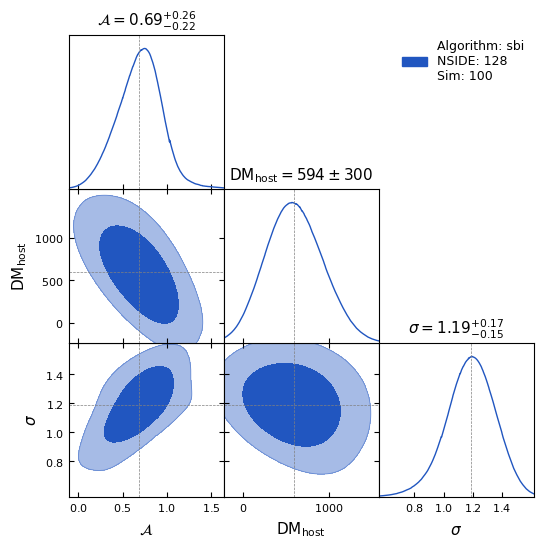

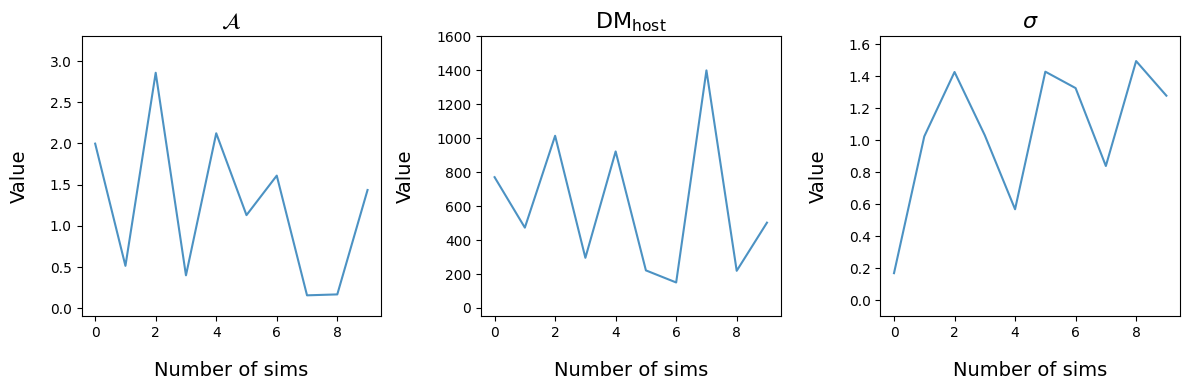

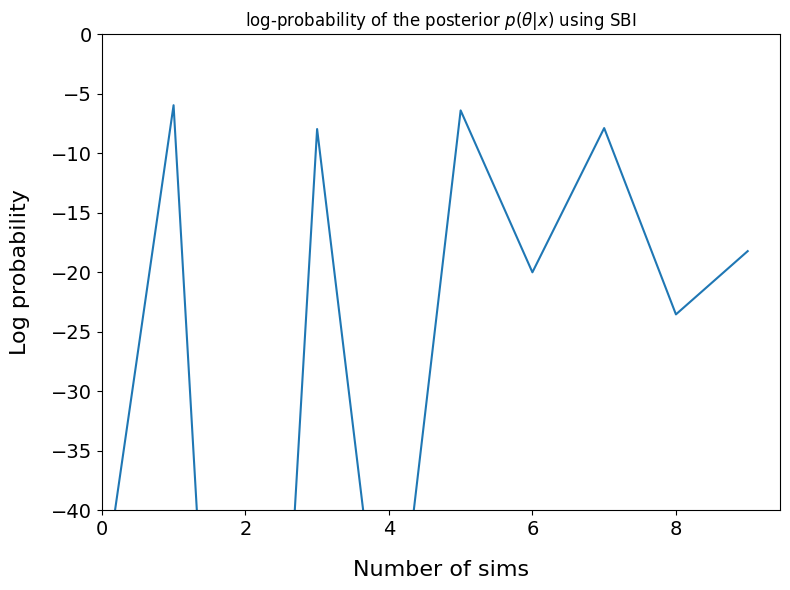



Complete, total time: 9.14 sec


In [20]:
posterior, observation, samples_arr, simulated_data, simulated_theta = sbi_instance.infer(algorithm='SNPE',
                                                                                          num_sample=num_sample, 
                                                                                          num_rounds=num_rounds, 
                                                                                          num_sims_in_round=num_sims_in_round,
                                                                                          num_walkers=num_walkers,
                                                                                          compression=False,
                                                                                          plot_figures=['contour', 'prior', 'likelihood', 'coverage', 'validation'],
                                                                                          save_data=True,
                                                                                          verbose=False)

Simulating Data
Algorithm: TSNPE
lognormal host, using Un-compressed DM

Run 1/2


Running 5 simulations.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 79 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Elapsed time after 1 run: 12.24 sec, Remaining time: 12.24 sec
Run 2/2
The `RestrictedPrior` rejected 50.5%
                of prior samples. You will get a speed-up of
                101.9%.


Running 5 simulations.:   0%|          | 0/5 [00:00<?, ?it/s]

 Neural network successfully converged after 83 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

Elapsed time after 2 run: 22.49 sec, Remaining time: 0.00 sec

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]



Complete, total time: 22.52 sec
Device: cuda


/home/koustav/.local/lib/python3.10/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


 Neural network successfully converged after 84 epochs.

/home/koustav/.local/lib/python3.10/site-packages/sbi/utils/posterior_ensemble.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights = torch.tensor(weights) / sum(weights)


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Removed no burn in


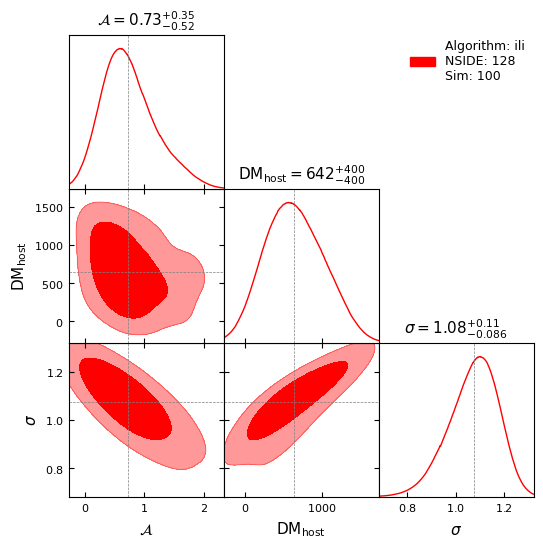

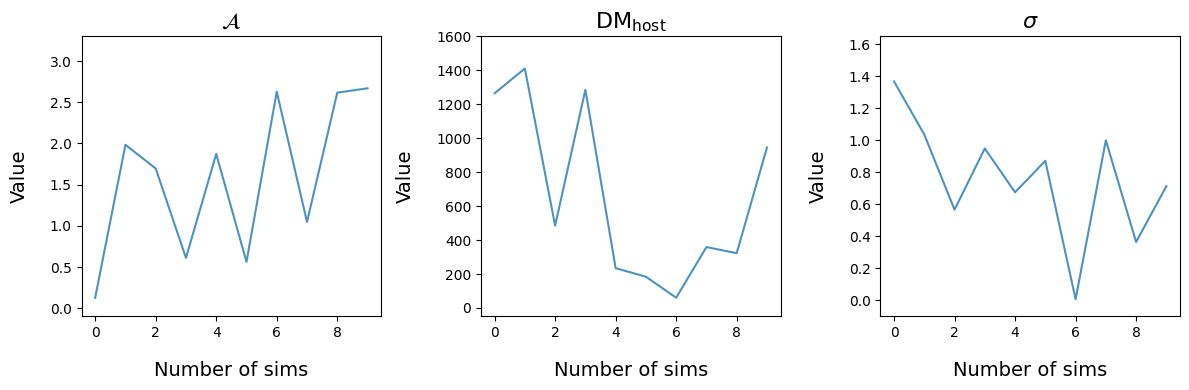



Type Fig: <class 'matplotlib.figure.Figure'>




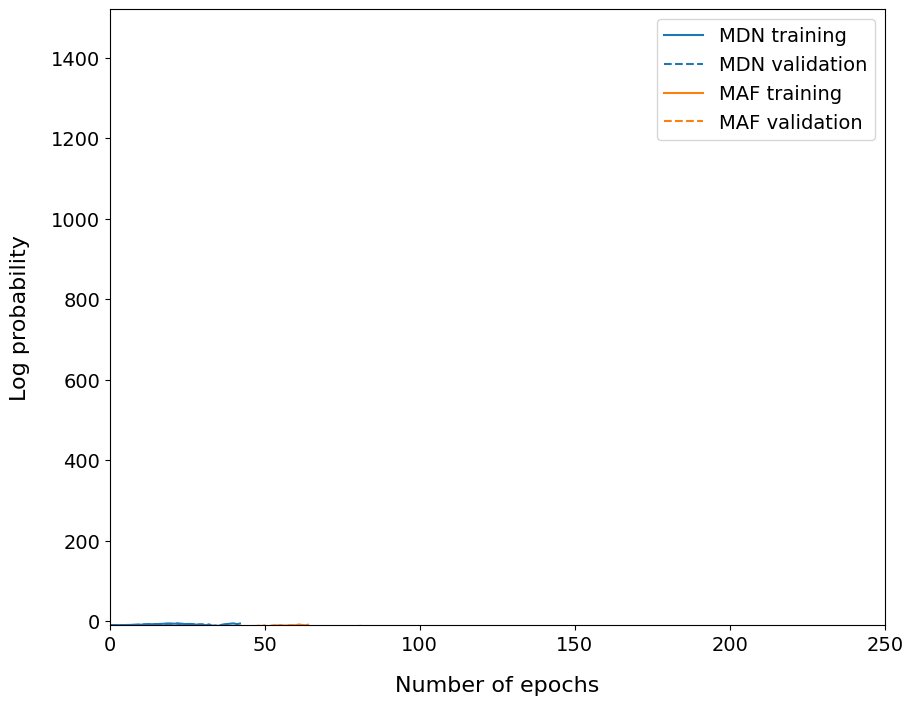

/home/koustav/Python/0000. Public code/FastNeuralBursts/inference.py:179: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  observation = torch.Tensor([observation]).to(device)


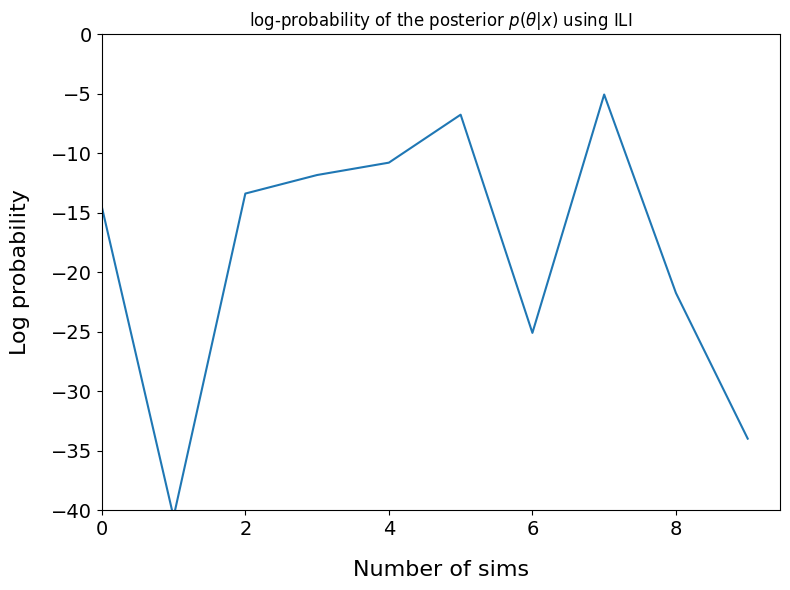

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.33it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




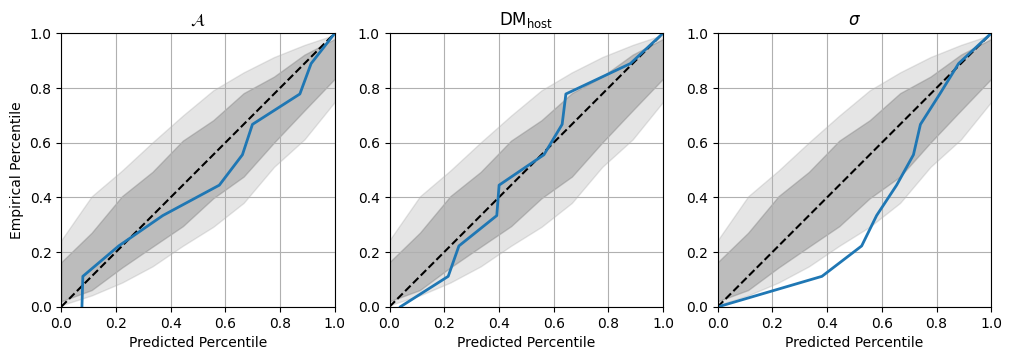

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.24it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




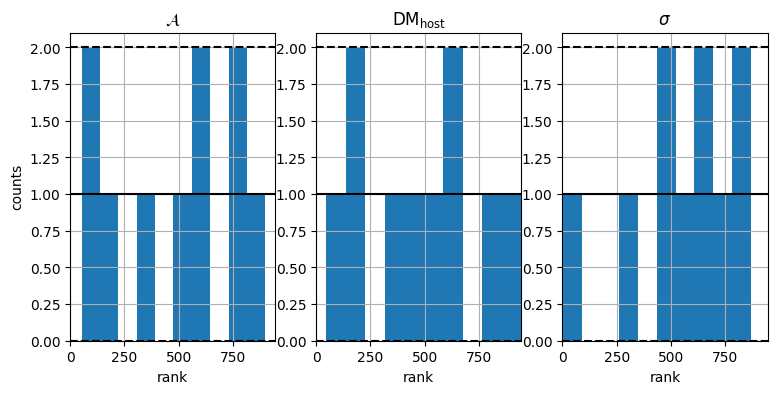

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.74it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




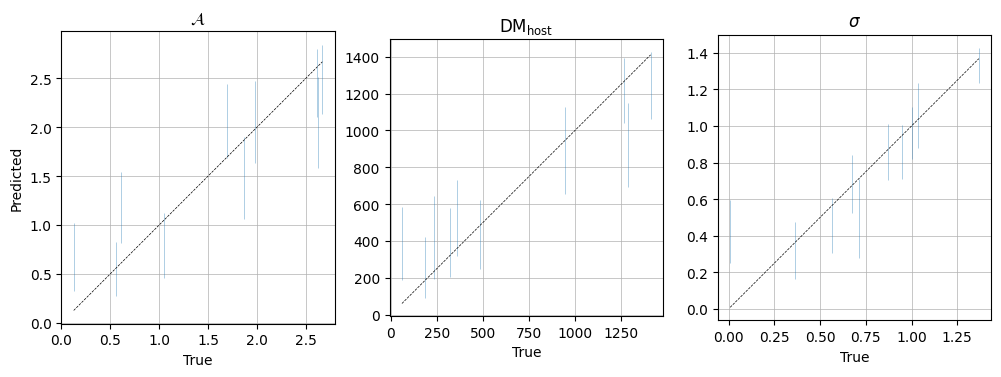

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1356.39it/s]




Type Fig: (<class 'list'>, <class 'matplotlib.figure.Figure'>)




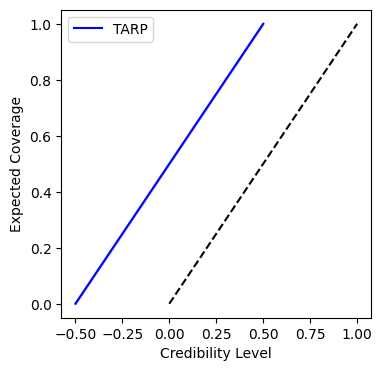



Complete, total time: 20.277 sec


In [21]:
posterior_ili, observation, samples_arr_ili, simulated_data_ili, simulated_theta_ili, summaries = sbi_instance.infer_ili(algorithm='TSNPE',
                                                                                                                         num_sample=num_sample, 
                                                                          num_rounds=num_rounds, 
                                                                          num_sims_in_round=num_sims_in_round,
                                                                          num_walkers=num_walkers,
                                                                          compression=False,
                                                                          plot_figures=['contour', 'prior', 'likelihood', 'coverage_test', 'validation'],
                                                                        model_for_coverage=['ensemble'],
                                                                     coverage_list = ["coverage", "histogram", "predictions", "tarp"],
                                                                          save_data=True,
                                                                          verbose=False)